In [ ]:
import os, time, random, torch

# IMPORTANT: Fix for PyTorch/IPython compatibility issue
# This must run BEFORE importing torch to avoid decorator conflicts
# This fixes the "disable() got an unexpected keyword argument 'wrapping'" error

# Method 1: Try to disable dynamo via environment variable (needs to be set before import)
os.environ.setdefault('TORCH_COMPILE_DISABLE', '1')
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Method 2: Patch torch._dynamo.disable decorator after import
try:
    import torch._dynamo
    # Patch the disable function to ignore the 'wrapping' parameter
    if hasattr(torch._dynamo, 'disable'):
        def patched_disable(fn=None, *args, **kwargs):
            # Remove problematic 'wrapping' parameter if present
            if 'wrapping' in kwargs:
                kwargs.pop('wrapping')
            if fn is None:
                # Decorator usage: @disable
                return lambda f: f
            # Function usage: disable(fn) or disable(fn, **kwargs)
            # Simply return the function unwrapped to avoid recursion
            # The original disable was causing issues, so we bypass it entirely
            return fn
        torch._dynamo.disable = patched_disable
except Exception as e:
    print(f"Warning: Could not patch torch._dynamo: {e}")
    pass  # If patching fails, continue anyway

from torchtext import data
from collections import defaultdict, Counter
import numpy as np

os.environ['GENSIM_DATA_DIR'] = os.path.join(os.getcwd(), 'gensim-data')

import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from utils import data_prep

In [2]:
SEED = 42
train_data, validation_data, test_data, LABEL, TEXT, pretrained_embed = data_prep(SEED)

[*] Prepping Data...
[+] Test set formed!
[+] Train and Validation sets formed!
[+] Data prepped successfully!
[*] Retrieving pretrained word embeddings...
[*] Loading fasttext model...
[+] Model loaded!
[*] Forming embedding matrix...
[+] Embedding matrix formed!
[+] Embeddings retrieved successfully!

Label distribution in training set:
- ABBR: 69 samples (1.58%)
- DESC: 930 samples (21.32%)
- ENTY: 1000 samples (22.93%)
- HUM: 978 samples (22.42%)
- LOC: 668 samples (15.31%)
- NUM: 717 samples (16.44%)
Total samples: 4362, Sum of percentages: 100.00%


In [4]:
TEXT.vocab

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
### Part 2: Model Training & Evaluation - RNN

# Build vocabulary for labels
LABEL.build_vocab(train_data)
num_classes = len(LABEL.vocab)
print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {LABEL.vocab.itos}")

# Create iterators for batching (inline for easier debugging)
# train_iterator = data.BucketIterator(...)
# val_iterator = data.BucketIterator(...)
# test_iterator = data.BucketIterator(...)
# (Used directly in Part 2 execution below)


class SimpleRNNClassifier(nn.Module):
    """
    Simple RNN for topic classification (Baseline - no dropout).
    Uses pretrained embeddings (learnable/updated during training) with OOV mitigation 
    and aggregates word representations to sentence representation using the last hidden state.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=1, dropout=0.0, padding_idx=0, pretrained_embeddings=None):
        super(SimpleRNNClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # Embedding layer initialized with pretrained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # IMPORTANT: Make embeddings learnable (updated during training)
            # This allows fine-tuning of embeddings including OOV words handled by FastText
            self.embedding.weight.requires_grad = True
        
        # Simple RNN layer (no dropout in baseline)
        self.rnn = nn.RNN(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.0  # No dropout in baseline
        )
        
        # Removed: Dropout layer (baseline has no regularization)
        # self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len]
        # text_lengths: [batch_size]
        
        # Embed the input
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        
        # Get dimensions
        batch_size = embedded.size(0)
        seq_len = embedded.size(1)
        
        # Handle text_lengths: ensure it's a 1D tensor with batch_size elements
        text_lengths_flat = text_lengths.flatten().cpu().long()
        
        # text_lengths should have exactly batch_size elements (one length per batch item)
        if len(text_lengths_flat) != batch_size:
            raise ValueError(
                f"text_lengths size mismatch: got {len(text_lengths_flat)} elements, "
                f"expected {batch_size} (batch_size). text_lengths.shape={text_lengths.shape}, "
                f"text.shape={text.shape}, embedded.shape={embedded.shape}"
            )
        
        # Clamp lengths to be at most the sequence length (safety check)
        text_lengths_clamped = torch.clamp(text_lengths_flat, min=1, max=seq_len)
        
        # Pack the padded sequences for efficient processing
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths_clamped, batch_first=True, enforce_sorted=False
        )
        
        # Pass through RNN
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden: [n_layers, batch_size, hidden_dim]
        
        # Use the last hidden state from the last layer
        last_hidden = hidden[-1]  # [batch_size, hidden_dim]
        
        # Removed: Apply dropout (baseline has no regularization)
        # last_hidden = self.dropout(last_hidden)
        
        # Pass through fully connected layer
        output = self.fc(last_hidden)  # [batch_size, output_dim]
        
        return output


# Utility function for counting parameters
def count_parameters(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training and evaluation functions removed - code is now inline below for easier debugging


Number of classes: 6
Classes: ['ENTY', 'HUM', 'DESC', 'NUM', 'LOC', 'ABBR']


In [7]:
print(len(TEXT.vocab))

8118


Training order:
1. Word aggregation
2. Hyperparameters tuning
3. Regularization

In [8]:
# ============================================================================
# Part 2: Initial Simple RNN Model Training
# ============================================================================

print("\n" + "="*80)
print("PART 2: SIMPLE RNN MODEL TRAINING")
print("="*80)

# Get pretrained embeddings from Part 1 (frozen embeddings)
# TODO: Check if this step is redundant
pretrained_embeddings = pretrained_embed.weight.data

# Get embedding dimension and vocab size from the fasttext embedding layer
embedding_dim = pretrained_embed.weight.shape[1]
embedding_vocab_size = pretrained_embed.weight.shape[0]  # Vocab size from saved embedding

# Verify vocab sizes match (they might differ if vocab was rebuilt)
print(f"TEXT.vocab size: {len(TEXT.vocab)}")
print(f"FastText embedding vocab size: {embedding_vocab_size}")

# Hyperparameters
BATCH_SIZE = 64
HIDDEN_DIM = 256
N_LAYERS = 1
DROPOUT = 0.0  # Baseline: no dropout
N_EPOCHS = 100
LEARNING_RATE = 0.001
# Removed: PATIENCE = 10  # Baseline: no early stopping

# Create data iterators (inline for easier debugging)
# Note: Different sequence lengths per batch are normal - BucketIterator groups similar-length sequences
train_iterator = data.BucketIterator(
    train_data,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,  # Shuffle for training
    device=device
)

val_iterator = data.BucketIterator(
    validation_data,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,  # No shuffle for validation (deterministic)
    device=device
)

test_iterator = data.BucketIterator(
    test_data,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,  # No shuffle for test (deterministic)
    device=device
)

# Initialize simple RNN model (Baseline)
# Use vocab size from loaded embedding to match the saved weights exactly
model = SimpleRNNClassifier(
    vocab_size=embedding_vocab_size,  # Must match saved embedding vocab size
    embedding_dim=embedding_dim,
    hidden_dim=HIDDEN_DIM,
    output_dim=num_classes,
    n_layers=N_LAYERS,
    dropout=0.0,  # Baseline: no dropout
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"\n>>> Training Baseline RNN Model")
print(f"Configuration:")
print(f"  - Hidden Dim: {HIDDEN_DIM}")
print(f"  - Layers: {N_LAYERS}")
print(f"  - Dropout: {DROPOUT} (Baseline: no regularization)")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Epochs: {N_EPOCHS} (no early stopping)")
print(f"  - Embedding Dim: {embedding_dim} (FastText)")
print(f"  - Embeddings: LEARNABLE (updated during training)")
print(f"  - OOV Handling: FastText subword embeddings + trainable <unk> token")

# ============================================================================
# Helper function to process batches consistently
# ============================================================================

def process_batch(batch, debug=False):
    """
    Process a batch from BucketIterator, handling text transpose correctly.
    Returns: text, text_lengths, labels (all properly formatted)
    """
    text, text_lengths = batch.text
    labels = batch.label
    
    if debug:
        print(f"DEBUG BATCH - text shape: {text.shape}, text_lengths shape: {text_lengths.shape}, labels shape: {labels.shape}")
    
    # torchtext BucketIterator returns text as [seq_len, batch_size] by default
    # We need [batch_size, seq_len] for batch_first=True in the model
    expected_batch_size = labels.shape[0]
    
    if text.dim() == 2:
        if text.shape[1] == expected_batch_size and len(text_lengths) == expected_batch_size:
            # text is [seq_len, batch_size], transpose to [batch_size, seq_len]
            text = text.transpose(0, 1)
            if debug:
                print(f"DEBUG BATCH - Transposed text to [batch_size, seq_len]: {text.shape}")
        elif text.shape[0] == expected_batch_size and len(text_lengths) == expected_batch_size:
            # text is already [batch_size, seq_len]
            if debug:
                print(f"DEBUG BATCH - text already in correct format: {text.shape}")
        else:
            raise ValueError(
                f"Cannot determine text format: text.shape={text.shape}, "
                f"text_lengths.shape={text_lengths.shape}, labels.shape={labels.shape}"
            )
    
    # Verify dimensions match
    assert text.shape[0] == len(text_lengths) == labels.shape[0], \
        f"Batch size mismatch: text.shape[0]={text.shape[0]}, len(text_lengths)={len(text_lengths)}, labels.shape[0]={labels.shape[0]}"
    
    return text, text_lengths, labels

# Set seeds for reproducibility
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Note: PyTorch/IPython compatibility fix is already applied in cell 0
# The torch._dynamo.disable decorator has been patched to handle the 'wrapping' parameter

# ============================================================================
# Training Loop (inline for easier debugging)
# ============================================================================

best_val_acc = 0
# Removed: patience_counter = 0  # Baseline: no early stopping

train_losses = []
train_accs = []
val_losses = []
val_accs = []

print(f"\nStarting training for {N_EPOCHS} epochs...")  # Removed "up to" - no early stopping
print(f"Device: {device}")
print(f"Trainable parameters: {count_parameters(model):,}")
print(f"Embedding layer learnable: {model.embedding.weight.requires_grad}")
# Removed: print(f"Early stopping patience: {PATIENCE} epochs")  # Baseline: no early stopping
print("-" * 80)

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    # ========================================================================
    # Training for one epoch (inline)
    # ========================================================================
    model.train()
    train_epoch_loss = 0
    train_all_preds = []
    train_all_labels = []
    
    batch_idx = 0
    for batch in train_iterator:
        # Process batch (with debug only for first batch)
        text, text_lengths, labels = process_batch(batch, debug=(batch_idx == 0))
        batch_idx += 1
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(text, text_lengths)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        
        # Backward pass
        loss.backward()
        
        # Removed: Gradient clipping (baseline has no gradient clipping)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update weights
        optimizer.step()
        
        train_epoch_loss += loss.item()
        
        # Store predictions and labels for metrics
        preds = torch.argmax(predictions, dim=1)
        train_all_preds.extend(preds.cpu().numpy())
        train_all_labels.extend(labels.cpu().numpy())
    
    # Calculate training accuracy
    train_acc = accuracy_score(train_all_labels, train_all_preds)
    train_loss = train_epoch_loss / len(train_iterator)
    
    # ========================================================================
    # Validation evaluation (inline)
    # ========================================================================
    model.eval()
    val_epoch_loss = 0
    val_all_preds = []
    val_all_labels = []
    
    with torch.no_grad():
        for batch in val_iterator:
            # Process batch consistently with training
            text, text_lengths, labels = process_batch(batch, debug=False)
            
            # Forward pass
            predictions = model(text, text_lengths)
            
            # Calculate loss
            loss = criterion(predictions, labels)
            val_epoch_loss += loss.item()
            
            # Store predictions and labels
            preds = torch.argmax(predictions, dim=1)
            val_all_preds.extend(preds.cpu().numpy())
            val_all_labels.extend(labels.cpu().numpy())
    
    # Calculate validation accuracy
    val_acc = accuracy_score(val_all_labels, val_all_preds)
    val_loss = val_epoch_loss / len(val_iterator)
    
    # ========================================================================
    # Logging (without early stopping)
    # ========================================================================
    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'Epoch: {epoch+1:02}/{N_EPOCHS} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
    print(f'\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%')
    
    # Track best model (but don't stop early - baseline trains for all epochs)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Save best model
        torch.save(model.state_dict(), 'rnn_simple_best.pt')
        print(f'\t>>> New best model saved with Val Acc: {val_acc*100:.2f}%')
    # Removed: Early stopping break logic (baseline trains for all epochs)

print("-" * 80)
print(f"Training completed! Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Total epochs trained: {N_EPOCHS}")


PART 2: SIMPLE RNN MODEL TRAINING
TEXT.vocab size: 8118
FastText embedding vocab size: 8118

>>> Training Baseline RNN Model
Configuration:
  - Hidden Dim: 256
  - Layers: 1
  - Dropout: 0.0 (Baseline: no regularization)
  - Learning Rate: 0.001
  - Batch Size: 64
  - Epochs: 100 (no early stopping)
  - Embedding Dim: 300 (FastText)
  - Embeddings: LEARNABLE (updated during training)
  - OOV Handling: FastText subword embeddings + trainable <unk> token

Starting training for 100 epochs...
Device: cuda
Trainable parameters: 2,579,790
Embedding layer learnable: True
--------------------------------------------------------------------------------
DEBUG BATCH - text shape: torch.Size([8, 64]), text_lengths shape: torch.Size([64]), labels shape: torch.Size([64])
DEBUG BATCH - Transposed text to [batch_size, seq_len]: torch.Size([64, 8])
Epoch: 01/100 | Time: 0m 1s
	Train Loss: 1.5937 | Train Acc: 29.41%
	Val Loss: 1.2681 | Val Acc: 49.91%
	>>> New best model saved with Val Acc: 49.91%
DEBU

In [9]:
# ============================================================================
# Validation Set Evaluation (inline) - Evaluate best model on validation set
# ============================================================================

print("\n" + "="*80)
print("VALIDATION SET EVALUATION (Best Model)")
print("="*80)

# Load best model and evaluate on validation set
model.load_state_dict(torch.load('rnn_simple_best.pt'))

model.eval()
val_eval_loss = 0
val_eval_preds = []
val_eval_labels = []
val_eval_probs = []  # Store probabilities for AUC-ROC

with torch.no_grad():
    for batch in val_iterator:
        text, text_lengths = batch.text
        labels = batch.label
        
        # Process batch consistently
        text, text_lengths, labels = process_batch(batch, debug=False)
        
        # Forward pass
        predictions = model(text, text_lengths)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        val_eval_loss += loss.item()
        
        # Store predictions, labels, and probabilities
        probs = torch.softmax(predictions, dim=1)
        preds = torch.argmax(predictions, dim=1)
        val_eval_preds.extend(preds.cpu().numpy())
        val_eval_labels.extend(labels.cpu().numpy())
        val_eval_probs.extend(probs.cpu().numpy())

# Calculate validation metrics
val_eval_acc = accuracy_score(val_eval_labels, val_eval_preds)
val_eval_f1 = f1_score(val_eval_labels, val_eval_preds, average='weighted')
val_eval_loss_final = val_eval_loss / len(val_iterator)

# Calculate AUC-ROC (one-vs-rest for multiclass)
try:
    val_eval_probs_array = np.array(val_eval_probs)
    val_eval_labels_bin = label_binarize(val_eval_labels, classes=range(num_classes))
    val_eval_auc = roc_auc_score(val_eval_labels_bin, val_eval_probs_array, average='weighted', multi_class='ovr')
except Exception as e:
    print(f"Warning: Could not calculate AUC-ROC: {e}")
    val_eval_auc = 0.0

print(f"\n>>> Validation Set Results (Best Model):")
print(f"Validation Loss: {val_eval_loss_final:.4f}")
print(f"Validation Accuracy: {val_eval_acc*100:.2f}%")
print(f"Validation F1 Score: {val_eval_f1:.4f}")
print(f"Validation AUC-ROC: {val_eval_auc:.4f}")

# ============================================================================
# Test Set Evaluation (inline)
# ============================================================================

print("\n" + "="*80)
print("TEST SET EVALUATION")
print("="*80)

model.eval()
test_epoch_loss = 0
test_all_preds = []
test_all_labels = []
test_all_probs = []  # Store probabilities for AUC-ROC

with torch.no_grad():
    for batch in test_iterator:
        text, text_lengths = batch.text
        labels = batch.label
        
        # Process batch consistently
        text, text_lengths, labels = process_batch(batch, debug=False)
        
        # Forward pass
        predictions = model(text, text_lengths)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        test_epoch_loss += loss.item()
        
        # Store predictions, labels, and probabilities
        probs = torch.softmax(predictions, dim=1)
        preds = torch.argmax(predictions, dim=1)
        test_all_preds.extend(preds.cpu().numpy())
        test_all_labels.extend(labels.cpu().numpy())
        test_all_probs.extend(probs.cpu().numpy())

# Calculate test metrics
test_acc = accuracy_score(test_all_labels, test_all_preds)
test_f1 = f1_score(test_all_labels, test_all_preds, average='weighted')
test_loss = test_epoch_loss / len(test_iterator)

# Calculate AUC-ROC (one-vs-rest for multiclass)
try:
    test_all_probs_array = np.array(test_all_probs)
    test_all_labels_bin = label_binarize(test_all_labels, classes=range(num_classes))
    test_auc = roc_auc_score(test_all_labels_bin, test_all_probs_array, average='weighted', multi_class='ovr')
except Exception as e:
    print(f"Warning: Could not calculate AUC-ROC: {e}")
    test_auc = 0.0

print(f"\n>>> Test Set Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")

print("\n" + "="*80)
print("PART 2 INITIAL TRAINING COMPLETE")
print("="*80)


VALIDATION SET EVALUATION (Best Model)

>>> Validation Set Results (Best Model):
Validation Loss: 1.1835
Validation Accuracy: 68.26%
Validation F1 Score: 0.6779
Validation AUC-ROC: 0.8943

TEST SET EVALUATION

>>> Test Set Results:
Test Loss: 0.7079
Test Accuracy: 79.20%
Test F1 Score: 0.7921
Test AUC-ROC: 0.9388

PART 2 INITIAL TRAINING COMPLETE


In [10]:
# ============================================================================
# Part 2.2: Sequential Hyperparameter Tuning (One Variable at a Time)
# ============================================================================

print("\n" + "="*80)
print("PART 2.2: SEQUENTIAL HYPERPARAMETER TUNING")
print("="*80)

# ============================================================================
# ============================================================================
# Step 0: Epoch + Early Stopping Configuration Tuning
# ============================================================================
print("\n" + "="*80)
print("STEP 0: EPOCH + EARLY STOPPING TUNING")
print("="*80)
print("Testing different MAX_EPOCHS and PATIENCE configurations")

# Test different epoch and patience configurations
max_epochs_options = [100, 200, 300]
patience = 10

# Use baseline config for testing epoch settings
baseline_config = {
    'lr': 0.001,
    'batch_size': 64,
    'hidden_dim': 256,
    'optimizer': 'Adam'
}

step0_configs = []
for max_epochs in max_epochs_options:
        step0_configs.append({
            'config': baseline_config.copy(),
            'max_epochs': max_epochs,
            'patience': patience
        })

print(f"Total combinations to test: {len(step0_configs)}")
print("Combinations (Max_Epochs, Patience):")
for idx, ep_config in enumerate(step0_configs, 1):
    print(f"  {idx}. Max_Epochs={ep_config['max_epochs']}, Patience={ep_config['patience']}")

# Helper function to train with specific epoch/patience settings
def train_and_evaluate_with_epochs(config, max_epochs, patience, config_name="config"):
    """Train a model for specific number of epochs WITHOUT early stopping"""
    print(f"\n>>> Testing: {config_name}")
    print(f"    LR={config['lr']}, Batch={config['batch_size']}, Hidden={config['hidden_dim']}, Opt={config['optimizer']}")
    print(f"    Epochs={max_epochs} (NO early stopping - training for full {max_epochs} epochs)")
    
    # Create iterators with specific batch size
    train_iter = data.BucketIterator(
        train_data,
        batch_size=config['batch_size'],
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=True,
        device=device
    )
    
    val_iter = data.BucketIterator(
        validation_data,
        batch_size=config['batch_size'],
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=False,
        device=device
    )
    
    # Reset random seeds INSIDE function to ensure fresh model for each config
    # This is critical to ensure each max_epochs config starts from scratch
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Create model with specific hidden dimension
    model = SimpleRNNClassifier(
        vocab_size=embedding_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=config['hidden_dim'],
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=0.0,  # Baseline: no dropout
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings
    ).to(device)
    
    # Select optimizer
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)
    elif config['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=config['lr'])
    
    # Training loop WITHOUT early stopping - train for full num_epochs
    best_val_acc = 0.0
    best_val_acc_at_epoch = 0
    final_val_acc = 0.0
    
    for epoch in range(max_epochs):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        # Track best validation accuracy (but don't stop early)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_acc_at_epoch = epoch + 1
        
        final_val_acc = val_acc  # Store final epoch's validation accuracy
        
        # Optional: print progress every 10 epochs or at the end
        if (epoch + 1) % 10 == 0 or (epoch + 1) == max_epochs:
            print(f"    Epoch {epoch+1}/{max_epochs}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    print(f"    Final Val Acc: {final_val_acc*100:.2f}% | Best Val Acc: {best_val_acc*100:.2f}% (at epoch {best_val_acc_at_epoch}/{max_epochs})")
    return best_val_acc, best_val_acc_at_epoch, max_epochs

step0_results = []
for idx, ep_config in enumerate(step0_configs):
    # Set fixed seed for reproducibility - ensures consistent batch ordering
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    val_acc, best_epoch, total_epochs = train_and_evaluate_with_epochs(
        ep_config['config'],
        ep_config['max_epochs'],
        ep_config['patience'],
        f"Step 0 Config {idx+1}/{len(step0_configs)}"
    )
    step0_results.append({
        'num_epochs': ep_config['max_epochs'],
        'val_acc': val_acc,
        'best_epoch': best_epoch,
        'total_epochs': total_epochs
    })

# Find best epoch configuration
best_step0 = max(step0_results, key=lambda x: x['val_acc'])
BEST_EPOCHS = best_step0['num_epochs']

# Set appropriate MAX_EPOCHS and PATIENCE for subsequent steps
# Use the best number of epochs with some buffer, and set a reasonable patience
MAX_EPOCHS = BEST_EPOCHS
PATIENCE = 7  # Default patience for early stopping in subsequent steps

print(f"\n>>> Step 0 Results:")
print(f"{'#':<4} {'Epochs':<8} {'Val Acc':<10} {'Best At Epoch':<15} {'Total Trained':<15}")
print("-" * 60)
for idx, result in enumerate(step0_results, 1):
    print(f"{idx:<4} {result['num_epochs']:<8} {result['val_acc']*100:<10.2f}% {result['best_epoch']:<15} {result['total_epochs']:<15}")
print(f"\n>>> Best from Step 0: Epochs={BEST_EPOCHS}, Val Acc={best_step0['val_acc']*100:.2f}%")
print(f"    Best validation accuracy was achieved at epoch {best_step0['best_epoch']} out of {best_step0['total_epochs']}")
print(f"\n>>> Using MAX_EPOCHS={MAX_EPOCHS} and PATIENCE={PATIENCE} for subsequent steps (with early stopping)")

# Helper function to train and evaluate a model configuration
def train_and_evaluate(config, config_name="config"):
    """Train a model with given configuration and return validation accuracy"""
    print(f"\n>>> Testing: {config_name}")
    print(f"    LR={config['lr']}, Batch={config['batch_size']}, Hidden={config['hidden_dim']}, Opt={config['optimizer']}")
    
    # Create iterators with specific batch size
    train_iter = data.BucketIterator(
        train_data,
        batch_size=config['batch_size'],
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=True,
        device=device
    )
    
    val_iter = data.BucketIterator(
        validation_data,
        batch_size=config['batch_size'],
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=False,
        device=device
    )
    
    # Create model with specific hidden dimension
    model = SimpleRNNClassifier(
        vocab_size=embedding_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=config['hidden_dim'],
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=0.0,  # Baseline: no dropout
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings
    ).to(device)
    
    # Select optimizer
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=config['lr'])
    
    # Training loop with early stopping
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
    
    print(f"    Best Val Acc: {best_val_acc*100:.2f}% (stopped at epoch {epoch+1})")
    return best_val_acc, epoch + 1


PART 2.2: SEQUENTIAL HYPERPARAMETER TUNING

STEP 0: EPOCH + EARLY STOPPING TUNING
Testing different MAX_EPOCHS and PATIENCE configurations
Total combinations to test: 3
Combinations (Max_Epochs, Patience):
  1. Max_Epochs=100, Patience=10
  2. Max_Epochs=200, Patience=10
  3. Max_Epochs=300, Patience=10

>>> Testing: Step 0 Config 1/3
    LR=0.001, Batch=64, Hidden=256, Opt=Adam
    Epochs=100 (NO early stopping - training for full 100 epochs)
    Epoch 10/100: Train Acc=100.00%, Val Acc=64.77%
    Epoch 20/100: Train Acc=100.00%, Val Acc=64.59%
    Epoch 30/100: Train Acc=100.00%, Val Acc=64.22%
    Epoch 40/100: Train Acc=100.00%, Val Acc=64.68%
    Epoch 50/100: Train Acc=100.00%, Val Acc=65.05%
    Epoch 60/100: Train Acc=100.00%, Val Acc=65.23%
    Epoch 70/100: Train Acc=100.00%, Val Acc=64.95%
    Epoch 80/100: Train Acc=100.00%, Val Acc=64.59%
    Epoch 90/100: Train Acc=100.00%, Val Acc=64.68%
    Epoch 100/100: Train Acc=100.00%, Val Acc=64.77%
    Final Val Acc: 64.77% | Be

In [11]:
# ============================================================================
# Step 1: Group 1 - Learning Rate + Batch Size (Test Together)
# ============================================================================

# Helper function to train and evaluate a model configuration (uses best MAX_EPOCHS and PATIENCE from Step 0)
def train_and_evaluate(config, config_name="config"):
    """Train a model with given configuration and return validation accuracy"""
    print(f"\n>>> Testing: {config_name}")
    print(f"    LR={config['lr']}, Batch={config['batch_size']}, Hidden={config['hidden_dim']}, Opt={config['optimizer']}")
    
    # Create iterators with specific batch size
    train_iter = data.BucketIterator(
        train_data,
        batch_size=config['batch_size'],
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=True,
        device=device
    )
    
    val_iter = data.BucketIterator(
        validation_data,
        batch_size=config['batch_size'],
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=False,
        device=device
    )
    
    # Create model with specific hidden dimension
    model = SimpleRNNClassifier(
        vocab_size=embedding_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=config['hidden_dim'],
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=0.0,  # Baseline: no dropout
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings
    ).to(device)
    
    # Select optimizer
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)
    elif config['optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=config['lr'])
    
    # Training loop with early stopping (using best MAX_EPOCHS and PATIENCE from Step 0)
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
    
    print(f"    Best Val Acc: {best_val_acc*100:.2f}% (stopped at epoch {epoch+1})")
    return best_val_acc, epoch + 1
    
print("\n" + "="*80)
print("STEP 1: LEARNING RATE + BATCH SIZE TUNING")
print("="*80)
print("Testing ALL combinations of LR and Batch Size (they interact)")

# Test all combinations of learning rates and batch sizes
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32, 64, 128]

step1_configs = []
for lr in learning_rates:
    for batch_size in batch_sizes:
        step1_configs.append({
            'lr': lr,
            'batch_size': batch_size,
            'hidden_dim': 256,
            'optimizer': 'Adam'
        })

print(f"Total combinations to test: {len(step1_configs)}")
print("Combinations:")
for idx, config in enumerate(step1_configs, 1):
    print(f"  {idx}. LR={config['lr']}, Batch={config['batch_size']}")

step1_results = []
for idx, config in enumerate(step1_configs):
    # Set fixed seed for reproducibility
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    val_acc, epoch_stopped = train_and_evaluate(config, f"Step 1 Config {idx+1}/{len(step1_configs)}")
    step1_results.append({
        'config': config,
        'val_acc': val_acc,
        'epoch_stopped': epoch_stopped
    })

# Find best LR + Batch Size
best_step1 = max(step1_results, key=lambda x: x['val_acc'])
best_lr = best_step1['config']['lr']
best_batch_size = best_step1['config']['batch_size']

print(f"\n>>> Step 1 Results:")
print(f"{'#':<4} {'LR':<8} {'Batch':<7} {'Val Acc':<10} {'Epochs':<7}")
print("-" * 40)
for idx, result in enumerate(step1_results):
    c = result['config']
    print(f"{idx+1:<4} {c['lr']:<8} {c['batch_size']:<7} {result['val_acc']*100:<10.2f}% {result['epoch_stopped']:<7}")
print(f"\n>>> Best from Step 1: LR={best_lr}, Batch={best_batch_size}, Val Acc={best_step1['val_acc']*100:.2f}%")


STEP 1: LEARNING RATE + BATCH SIZE TUNING
Testing ALL combinations of LR and Batch Size (they interact)
Total combinations to test: 9
Combinations:
  1. LR=0.01, Batch=32
  2. LR=0.01, Batch=64
  3. LR=0.01, Batch=128
  4. LR=0.001, Batch=32
  5. LR=0.001, Batch=64
  6. LR=0.001, Batch=128
  7. LR=0.0001, Batch=32
  8. LR=0.0001, Batch=64
  9. LR=0.0001, Batch=128

>>> Testing: Step 1 Config 1/9
    LR=0.01, Batch=32, Hidden=256, Opt=Adam
    Early stopping at epoch 13, best val acc: 47.71%
    Best Val Acc: 47.71% (stopped at epoch 13)

>>> Testing: Step 1 Config 2/9
    LR=0.01, Batch=64, Hidden=256, Opt=Adam
    Early stopping at epoch 8, best val acc: 22.84%
    Best Val Acc: 22.84% (stopped at epoch 8)

>>> Testing: Step 1 Config 3/9
    LR=0.01, Batch=128, Hidden=256, Opt=Adam
    Early stopping at epoch 34, best val acc: 54.68%
    Best Val Acc: 54.68% (stopped at epoch 34)

>>> Testing: Step 1 Config 4/9
    LR=0.001, Batch=32, Hidden=256, Opt=Adam
    Early stopping at epoch 

In [12]:
# ============================================================================
# Step 2: Group 2 - Optimizer
# ============================================================================
print("\n" + "="*80)
print("STEP 2: OPTIMIZER")
print("="*80)
print(f"Using best LR={best_lr} and Batch={best_batch_size} from Step 1")

step2_configs = [
    {'lr': best_lr, 'batch_size': best_batch_size, 'hidden_dim': 256, 'optimizer': 'Adam'},
    {'lr': best_lr, 'batch_size': best_batch_size, 'hidden_dim': 256, 'optimizer': 'SGD'},
    {'lr': best_lr, 'batch_size': best_batch_size, 'hidden_dim': 256, 'optimizer': 'RMSprop'},
    {'lr': best_lr, 'batch_size': best_batch_size, 'hidden_dim': 256, 'optimizer': 'Adagrad'},
]

step2_results = []
for idx, config in enumerate(step2_configs):
    # Set fixed seed for reproducibility
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    val_acc, epoch_stopped = train_and_evaluate(config, f"Step 2 Config {idx+1}/{len(step2_configs)}")
    step2_results.append({
        'config': config,
        'val_acc': val_acc,
        'epoch_stopped': epoch_stopped
    })

# Find best Optimizer (and potentially adjusted LR)
best_step2 = max(step2_results, key=lambda x: x['val_acc'])
best_optimizer = best_step2['config']['optimizer']
final_lr = best_step2['config']['lr']  # May be different if SGD needed higher LR

print(f"\n>>> Step 2 Results:")
print(f"{'#':<4} {'LR':<8} {'Optimizer':<10} {'Val Acc':<10} {'Epochs':<7}")
print("-" * 45)
for idx, result in enumerate(step2_results):
    c = result['config']
    print(f"{idx+1:<4} {c['lr']:<8} {c['optimizer']:<10} {result['val_acc']*100:<10.2f}% {result['epoch_stopped']:<7}")
print(f"\n>>> Best from Step 2: LR={final_lr}, Optimizer={best_optimizer}, Val Acc={best_step2['val_acc']*100:.2f}%")


STEP 2: OPTIMIZER
Using best LR=0.0001 and Batch=32 from Step 1

>>> Testing: Step 2 Config 1/4
    LR=0.0001, Batch=32, Hidden=256, Opt=Adam
    Early stopping at epoch 26, best val acc: 81.38%
    Best Val Acc: 81.38% (stopped at epoch 26)

>>> Testing: Step 2 Config 2/4
    LR=0.0001, Batch=32, Hidden=256, Opt=SGD
    Early stopping at epoch 11, best val acc: 23.03%
    Best Val Acc: 23.03% (stopped at epoch 11)

>>> Testing: Step 2 Config 3/4
    LR=0.0001, Batch=32, Hidden=256, Opt=RMSprop
    Early stopping at epoch 24, best val acc: 82.66%
    Best Val Acc: 82.66% (stopped at epoch 24)

>>> Testing: Step 2 Config 4/4
    LR=0.0001, Batch=32, Hidden=256, Opt=Adagrad
    Early stopping at epoch 39, best val acc: 32.66%
    Best Val Acc: 32.66% (stopped at epoch 39)

>>> Step 2 Results:
#    LR       Optimizer  Val Acc    Epochs 
---------------------------------------------
1    0.0001   Adam       81.38     % 26     
2    0.0001   SGD        23.03     % 11     
3    0.0001   RMS

In [13]:
# ============================================================================
# Step 3: Hidden Dimension (Test Independently)
# ============================================================================
print("\n" + "="*80)
print("STEP 3: HIDDEN DIMENSION TUNING")
print("="*80)
print(f"Using best LR={final_lr}, Batch={best_batch_size}, Optimizer={best_optimizer} from Steps 1-2")

step3_configs = [
    {'lr': final_lr, 'batch_size': best_batch_size, 'hidden_dim': 128, 'optimizer': best_optimizer},
    {'lr': final_lr, 'batch_size': best_batch_size, 'hidden_dim': 256, 'optimizer': best_optimizer},
    {'lr': final_lr, 'batch_size': best_batch_size, 'hidden_dim': 512, 'optimizer': best_optimizer},
]

step3_results = []
for idx, config in enumerate(step3_configs):
    # Set fixed seed for reproducibility
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    val_acc, epoch_stopped = train_and_evaluate(config, f"Step 3 Config {idx+1}/{len(step3_configs)}")
    step3_results.append({
        'config': config,
        'val_acc': val_acc,
        'epoch_stopped': epoch_stopped
    })

# Find best Hidden Dimension
best_step3 = max(step3_results, key=lambda x: x['val_acc'])
best_hidden_dim = best_step3['config']['hidden_dim']

print(f"\n>>> Step 3 Results:")
print(f"{'#':<4} {'Hidden Dim':<12} {'Val Acc':<10} {'Epochs':<7}")
print("-" * 35)
for idx, result in enumerate(step3_results):
    c = result['config']
    print(f"{idx+1:<4} {c['hidden_dim']:<12} {result['val_acc']*100:<10.2f}% {result['epoch_stopped']:<7}")
print(f"\n>>> Best from Step 3: Hidden Dim={best_hidden_dim}, Val Acc={best_step3['val_acc']*100:.2f}%")


STEP 3: HIDDEN DIMENSION TUNING
Using best LR=0.0001, Batch=32, Optimizer=RMSprop from Steps 1-2

>>> Testing: Step 3 Config 1/3
    LR=0.0001, Batch=32, Hidden=128, Opt=RMSprop
    Early stopping at epoch 30, best val acc: 82.66%
    Best Val Acc: 82.66% (stopped at epoch 30)

>>> Testing: Step 3 Config 2/3
    LR=0.0001, Batch=32, Hidden=256, Opt=RMSprop
    Early stopping at epoch 24, best val acc: 82.66%
    Best Val Acc: 82.66% (stopped at epoch 24)

>>> Testing: Step 3 Config 3/3
    LR=0.0001, Batch=32, Hidden=512, Opt=RMSprop
    Early stopping at epoch 17, best val acc: 83.03%
    Best Val Acc: 83.03% (stopped at epoch 17)

>>> Step 3 Results:
#    Hidden Dim   Val Acc    Epochs 
-----------------------------------
1    128          82.66     % 30     
2    256          82.66     % 24     
3    512          83.03     % 17     

>>> Best from Step 3: Hidden Dim=512, Val Acc=83.03%


In [14]:
# ============================================================================
# Final Best Configuration Summary
# ============================================================================
print("\n" + "="*80)
print("HYPERPARAMETER TUNING COMPLETE - FINAL BEST CONFIGURATION")
print("="*80)

final_best_config = {
    'lr': final_lr,
    'batch_size': best_batch_size,
    'hidden_dim': best_hidden_dim,
    'optimizer': best_optimizer,
    'max_epochs': MAX_EPOCHS,
    'patience': PATIENCE
}

print(f"\n>>> Best Configuration Found:")
print(f"    Learning Rate: {final_best_config['lr']}")
print(f"    Batch Size: {final_best_config['batch_size']}")
print(f"    Hidden Dimension: {final_best_config['hidden_dim']}")
print(f"    Optimizer: {final_best_config['optimizer']}")
print(f"    Max Epochs: {final_best_config['max_epochs']} (with early stopping, patience={final_best_config['patience']})")
print(f"    Best Validation Accuracy: {best_step3['val_acc']*100:.2f}%")

print("\n" + "="*80)
print("SEQUENTIAL HYPERPARAMETER TUNING COMPLETE")
print("="*80)


HYPERPARAMETER TUNING COMPLETE - FINAL BEST CONFIGURATION

>>> Best Configuration Found:
    Learning Rate: 0.0001
    Batch Size: 32
    Hidden Dimension: 512
    Optimizer: RMSprop
    Max Epochs: 200 (with early stopping, patience=7)
    Best Validation Accuracy: 83.03%

SEQUENTIAL HYPERPARAMETER TUNING COMPLETE


In [15]:
# ============================================================================
# Word Aggregation Method Comparison
# ============================================================================
print("\n" + "="*80)
print("WORD AGGREGATION METHOD COMPARISON")
print("="*80)
print(f"Using best hyperparameters from tuning:")
print(f"    LR={final_lr}, Batch={best_batch_size}, Hidden={best_hidden_dim}, Optimizer={best_optimizer}")
print(f"    Max Epochs={MAX_EPOCHS}, Patience={PATIENCE}")

# Extended RNN Classifier with multiple aggregation methods
class RNN_Classifier_Aggregation(nn.Module):
    """
    RNN for topic classification with multiple aggregation strategies.
    Uses pretrained embeddings (learnable/updated during training).
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers=1, dropout=0.0, padding_idx=0, pretrained_embeddings=None,
                 aggregation='last'):
        super(RNN_Classifier_Aggregation, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.aggregation = aggregation  # 'last', 'mean', 'max', 'attention'
        
        # Embedding layer initialized with pretrained embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # Make embeddings learnable (updated during training)
            self.embedding.weight.requires_grad = True
        
        # RNN layer
        self.rnn = nn.RNN(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.0  # No dropout in baseline
        )
        
        # Attention mechanism for aggregation (only created if needed)
        if aggregation == 'attention':
            self.attention = nn.Linear(hidden_dim, 1)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len]
        # text_lengths: [batch_size]
        
        # Embed the input
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        
        # Get dimensions
        batch_size = embedded.size(0)
        seq_len = embedded.size(1)
        
        # Handle text_lengths
        text_lengths_flat = text_lengths.flatten().cpu().long()
        if len(text_lengths_flat) != batch_size:
            raise ValueError(
                f"text_lengths size mismatch: got {len(text_lengths_flat)} elements, "
                f"expected {batch_size}"
            )
        
        # Clamp lengths
        text_lengths_clamped = torch.clamp(text_lengths_flat, min=1, max=seq_len)
        
        # Move to same device as text for mask operations later
        # Keep CPU version for pack_padded_sequence (requires CPU)
        # Create device version for mask operations later
        text_lengths_clamped_device = text_lengths_clamped.to(text.device)
        # Pack the padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths_clamped, batch_first=True, enforce_sorted=False
        )
        
        # Pass through RNN
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden: [n_layers, batch_size, hidden_dim]
        
        # Aggregate word representations to sentence representation
        if self.aggregation == 'last':
            # Use the last hidden state from the last layer
            sentence_repr = hidden[-1]  # [batch_size, hidden_dim]
            
        elif self.aggregation == 'mean':
            # Mean pooling over all outputs (ignoring padding)
            # Unpack the sequences first
            output, output_lengths = nn.utils.rnn.pad_packed_sequence(
                packed_output, batch_first=True
            )
            # output: [batch_size, seq_len, hidden_dim]
            
            # Create mask for padding
            mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths_clamped_device.unsqueeze(1)
            mask = mask.unsqueeze(2).float()  # [batch_size, seq_len, 1]
            
            # Apply mask and compute mean
            masked_output = output * mask
            sum_output = masked_output.sum(dim=1)  # [batch_size, hidden_dim]
            sentence_repr = sum_output / text_lengths_clamped_device.unsqueeze(1).float()
            
        elif self.aggregation == 'max':
            # Max pooling over all outputs
            output, output_lengths = nn.utils.rnn.pad_packed_sequence(
                packed_output, batch_first=True
            )
            # output: [batch_size, seq_len, hidden_dim]
            
            # Create mask for padding (set padding to -inf before max)
            mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths_clamped_device.unsqueeze(1)
            mask = mask.unsqueeze(2).float()  # [batch_size, seq_len, 1]
            
            masked_output = output * mask + (1 - mask) * float('-inf')
            sentence_repr, _ = torch.max(masked_output, dim=1)
            
        elif self.aggregation == 'attention':
            # Attention mechanism
            output, output_lengths = nn.utils.rnn.pad_packed_sequence(
                packed_output, batch_first=True
            )
            # output: [batch_size, seq_len, hidden_dim]
            
            # Compute attention scores
            attn_scores = self.attention(output).squeeze(2)  # [batch_size, seq_len]
            
            # Mask padding positions
            mask = torch.arange(seq_len, device=text.device).unsqueeze(0) < text_lengths_clamped_device.unsqueeze(1)
            attn_scores = attn_scores.masked_fill(~mask, float('-inf'))
            
            # Apply softmax
            attn_weights = torch.softmax(attn_scores, dim=1).unsqueeze(1)  # [batch_size, 1, seq_len]
            
            # Weighted sum
            sentence_repr = torch.bmm(attn_weights, output).squeeze(1)  # [batch_size, hidden_dim]
        
        # Pass through fully connected layer
        output = self.fc(sentence_repr)  # [batch_size, output_dim]
        
        return output

# Test different aggregation methods
aggregation_methods = ['last', 'mean', 'max', 'attention']

print(f"\nTesting {len(aggregation_methods)} aggregation methods:")
for method in aggregation_methods:
    print(f"  - {method}")

aggregation_results = []

for agg_method in aggregation_methods:
    print(f"\n{'='*80}")
    print(f"Testing Aggregation Method: {agg_method.upper()}")
    print(f"{'='*80}")
    
    # Set fixed seed for reproducibility - ensures consistent batch ordering
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    # Create iterators with best batch size
    train_iter = data.BucketIterator(
        train_data,
        batch_size=best_batch_size,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=True,
        device=device
    )
    
    val_iter = data.BucketIterator(
        validation_data,
        batch_size=best_batch_size,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=False,
        device=device
    )
    
    test_iter = data.BucketIterator(
        test_data,
        batch_size=best_batch_size,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=False,
        device=device
    )
    
    # Create model with best hyperparameters and specific aggregation method
    model = RNN_Classifier_Aggregation(
        vocab_size=embedding_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=best_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=0.0,  # Baseline: no dropout
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings,
        aggregation=agg_method
    ).to(device)
    
    # Select optimizer with best learning rate
    if best_optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=final_lr)
    elif best_optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9)
    elif best_optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=final_lr)
    elif best_optimizer == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=final_lr)
    
    # Training loop with early stopping
    best_val_acc = 0.0
    patience_counter = 0
    
    print(f"\n>>> Training model with {agg_method} aggregation...")
    
    for epoch in range(MAX_EPOCHS):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model for this aggregation method
            torch.save(model.state_dict(), f'rnn_agg_{agg_method}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    # Load best model and evaluate on test set
    model.load_state_dict(torch.load(f'rnn_agg_{agg_method}_best.pt'))
    model.eval()
    
    test_loss = 0
    test_preds = []
    test_labels = []
    test_probs = []
    
    with torch.no_grad():
        for batch in test_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            test_loss += loss.item()
            
            probs = torch.softmax(predictions, dim=1)
            preds = torch.argmax(predictions, dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
    
    # Calculate test metrics
    test_acc = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average='weighted')
    test_loss_avg = test_loss / len(test_iter)
    
    # Calculate AUC-ROC
    try:
        test_probs_array = np.array(test_probs)
        test_labels_bin = label_binarize(test_labels, classes=range(num_classes))
        test_auc = roc_auc_score(test_labels_bin, test_probs_array, average='weighted', multi_class='ovr')
    except Exception as e:
        print(f"    Warning: Could not calculate AUC-ROC: {e}")
        test_auc = 0.0
    
    aggregation_results.append({
        'method': agg_method,
        'val_acc': best_val_acc,
        'test_acc': test_acc,
        'test_f1': test_f1,
        'test_auc': test_auc,
        'test_loss': test_loss_avg
    })
    
    print(f"\n>>> Results for {agg_method} aggregation:")
    print(f"    Validation Acc: {best_val_acc*100:.2f}%")
    print(f"    Test Acc: {test_acc*100:.2f}%")
    print(f"    Test F1: {test_f1:.4f}")
    print(f"    Test AUC-ROC: {test_auc:.4f}")

# Print summary table
print(f"\n{'='*80}")
print("AGGREGATION METHOD COMPARISON - RESULTS SUMMARY")
print(f"{'='*80}")

print(f"\n>>> Results Summary:")
print(f"{'Method':<12} {'Val Acc':<10} {'Test Acc':<10} {'Test F1':<10} {'Test AUC':<10}")
print("-" * 55)
for result in aggregation_results:
    print(f"{result['method']:<12} {result['val_acc']*100:<10.2f}% {result['test_acc']*100:<10.2f}% "
          f"{result['test_f1']:<10.4f} {result['test_auc']:<10.4f}")

# Find best aggregation method
best_aggregation = max(aggregation_results, key=lambda x: x['val_acc'])

print(f"\n>>> Best Aggregation Method: {best_aggregation['method'].upper()}")
print(f"    Validation Accuracy: {best_aggregation['val_acc']*100:.2f}%")
print(f"    Test Accuracy: {best_aggregation['test_acc']*100:.2f}%")
print(f"    Test F1 Score: {best_aggregation['test_f1']:.4f}")
print(f"    Test AUC-ROC: {best_aggregation['test_auc']:.4f}")

print(f"\n{'='*80}")
print("AGGREGATION METHOD COMPARISON COMPLETE")
print(f"{'='*80}")


WORD AGGREGATION METHOD COMPARISON
Using best hyperparameters from tuning:
    LR=0.0001, Batch=32, Hidden=512, Optimizer=RMSprop
    Max Epochs=200, Patience=7

Testing 4 aggregation methods:
  - last
  - mean
  - max
  - attention

Testing Aggregation Method: LAST

>>> Training model with last aggregation...
    Epoch 10: Train Acc=92.43%, Val Acc=83.03%
    Early stopping at epoch 17, best val acc: 83.03%

>>> Results for last aggregation:
    Validation Acc: 83.03%
    Test Acc: 85.00%
    Test F1: 0.8399
    Test AUC-ROC: 0.9733

Testing Aggregation Method: MEAN

>>> Training model with mean aggregation...
    Epoch 10: Train Acc=91.98%, Val Acc=81.83%
    Epoch 20: Train Acc=96.74%, Val Acc=83.21%
    Early stopping at epoch 21, best val acc: 83.76%

>>> Results for mean aggregation:
    Validation Acc: 83.76%
    Test Acc: 87.60%
    Test F1: 0.8738
    Test AUC-ROC: 0.9701

Testing Aggregation Method: MAX

>>> Training model with max aggregation...
    Early stopping at epoch 

In [16]:
# ============================================================================
# Regularization: Baseline (No Regularization)
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION STEP 0: BASELINE (NO REGULARIZATION)")
print("="*80)
print(f"Using best hyperparameters from tuning:")
print(f"    LR={final_lr}, Batch={best_batch_size}, Hidden={best_hidden_dim}, Optimizer={best_optimizer}")
print(f"    Max Epochs={MAX_EPOCHS}, Patience={PATIENCE}")
print(f"    Best Aggregation Method: {best_aggregation['method'].upper()}")

# Baseline configuration
baseline_config = {
    'dropout': 0.0,
    'grad_clip': 0.0,
    'l1_lambda': 0.0,
    'l2_lambda': 0.0
}

print(f"\nBaseline Configuration:")
print(f"    Dropout: {baseline_config['dropout']}")
print(f"    Gradient Clipping: {baseline_config['grad_clip']}")
print(f"    L1 Lambda: {baseline_config['l1_lambda']}")
print(f"    L2 Lambda: {baseline_config['l2_lambda']}")

# Create iterators
train_iter = data.BucketIterator(
    train_data,
    batch_size=best_batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=True,
    device=device
)

val_iter = data.BucketIterator(
    validation_data,
    batch_size=best_batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

test_iter = data.BucketIterator(
    test_data,
    batch_size=best_batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    shuffle=False,
    device=device
)

# Create model
model = RNN_Classifier_Aggregation(
    vocab_size=embedding_vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=best_hidden_dim,
    output_dim=num_classes,
    n_layers=N_LAYERS,
    dropout=baseline_config['dropout'],
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings,
    aggregation=best_aggregation['method']
).to(device)

# Select optimizer
if best_optimizer == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=baseline_config['l2_lambda'])
elif best_optimizer == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=baseline_config['l2_lambda'])
elif best_optimizer == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=baseline_config['l2_lambda'])
elif best_optimizer == 'Adagrad':
    optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=baseline_config['l2_lambda'])

# Helper function for L1 regularization
def compute_l1_loss(model, l1_lambda):
    """Compute L1 regularization loss"""
    if l1_lambda > 0:
        return l1_lambda * sum(p.abs().sum() for p in model.parameters() if p.requires_grad)
    return 0.0

# Training loop
best_val_acc = 0.0
patience_counter = 0

print(f"\n>>> Training baseline model...")

for epoch in range(MAX_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    train_preds = []
    train_labels = []
    
    for batch in train_iter:
        text, text_lengths, labels = process_batch(batch, debug=False)
        optimizer.zero_grad()
        predictions = model(text, text_lengths)
        
        loss = criterion(predictions, labels)
        
        # Add L1 regularization
        if baseline_config['l1_lambda'] > 0:
            loss = loss + compute_l1_loss(model, baseline_config['l1_lambda'])
        
        loss.backward()
        
        # Gradient clipping
        if baseline_config['grad_clip'] > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), baseline_config['grad_clip'])
        
        optimizer.step()
        
        train_loss += loss.item()
        preds = torch.argmax(predictions, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
    
    train_acc = accuracy_score(train_labels, train_preds)
    
    # Validation
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for batch in val_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(predictions, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_acc = accuracy_score(val_labels, val_preds)
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'rnn_reg_baseline_best.pt')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
            break
    
    if (epoch + 1) % 10 == 0:
        print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")

# Evaluate on test set
model.load_state_dict(torch.load('rnn_reg_baseline_best.pt'))
model.eval()

test_loss = 0
test_preds = []
test_labels = []
test_probs = []

with torch.no_grad():
    for batch in test_iter:
        text, text_lengths, labels = process_batch(batch, debug=False)
        predictions = model(text, text_lengths)
        loss = criterion(predictions, labels)
        test_loss += loss.item()
        
        probs = torch.softmax(predictions, dim=1)
        preds = torch.argmax(predictions, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_loss_avg = test_loss / len(test_iter)

try:
    test_probs_array = np.array(test_probs)
    test_labels_bin = label_binarize(test_labels, classes=range(num_classes))
    test_auc = roc_auc_score(test_labels_bin, test_probs_array, average='weighted', multi_class='ovr')
except Exception as e:
    print(f"Warning: Could not calculate AUC-ROC: {e}")
    test_auc = 0.0

baseline_results = {
    'name': 'baseline',
    'dropout': baseline_config['dropout'],
    'grad_clip': baseline_config['grad_clip'],
    'l1_lambda': baseline_config['l1_lambda'],
    'l2_lambda': baseline_config['l2_lambda'],
    'val_acc': best_val_acc,
    'test_acc': test_acc,
    'test_f1': test_f1,
    'test_auc': test_auc
}

print(f"\n>>> Baseline Results:")
print(f"    Validation Acc: {best_val_acc*100:.2f}%")
print(f"    Test Acc: {test_acc*100:.2f}%")
print(f"    Test F1: {test_f1:.4f}")
print(f"    Test AUC-ROC: {test_auc:.4f}")

# Store for next steps
best_grad_clip = baseline_config['grad_clip']  # Will be updated in Step 1
best_dropout = baseline_config['dropout']  # Will be updated in Step 2
best_l1_lambda = baseline_config['l1_lambda']  # Will be updated in Step 3
best_l2_lambda = baseline_config['l2_lambda']  # Will be updated in Step 4


REGULARIZATION STEP 0: BASELINE (NO REGULARIZATION)
Using best hyperparameters from tuning:
    LR=0.0001, Batch=32, Hidden=512, Optimizer=RMSprop
    Max Epochs=200, Patience=7
    Best Aggregation Method: ATTENTION

Baseline Configuration:
    Dropout: 0.0
    Gradient Clipping: 0.0
    L1 Lambda: 0.0
    L2 Lambda: 0.0

>>> Training baseline model...
    Epoch 10: Train Acc=95.09%, Val Acc=84.68%
    Epoch 20: Train Acc=99.31%, Val Acc=83.21%
    Early stopping at epoch 22, best val acc: 85.87%

>>> Baseline Results:
    Validation Acc: 85.87%
    Test Acc: 89.60%
    Test F1: 0.8968
    Test AUC-ROC: 0.9713


In [17]:
# ============================================================================
# Regularization Step 1: Gradient Clipping Tuning
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION STEP 1: GRADIENT CLIPPING TUNING")
print("="*80)
print(f"Using baseline settings: dropout={best_dropout}, L1={best_l1_lambda}, L2={best_l2_lambda}")

# Test different gradient clipping values
grad_clip_options = [0.0, 1.0]  # 0.0 = no clipping, 1.0 = clip at 1.0

print(f"\nTesting gradient clipping values: {grad_clip_options}")

step1_results = []

for grad_clip in grad_clip_options:
    print(f"\n{'='*80}")
    print(f"Testing: Gradient Clipping = {grad_clip}")
    print(f"{'='*80}")
    
    # Create model with baseline settings
    model = RNN_Classifier_Aggregation(
        vocab_size=embedding_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=best_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=best_dropout,
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings,
        aggregation=best_aggregation['method']
    ).to(device)
    
    # Select optimizer
    if best_optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=best_l2_lambda)
    elif best_optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    
    # Training loop
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, labels)
            
            if best_l1_lambda > 0:
                loss = loss + compute_l1_loss(model, best_l1_lambda)
            
            loss.backward()
            
            if grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'rnn_reg_step1_gradclip{grad_clip}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    step1_results.append({
        'grad_clip': grad_clip,
        'val_acc': best_val_acc
    })
    
    print(f"    Result: Val Acc={best_val_acc*100:.2f}%")

# Find best gradient clipping
best_step1 = max(step1_results, key=lambda x: x['val_acc'])
best_grad_clip = best_step1['grad_clip']

print(f"\n>>> Step 1 Results:")
print(f"{'Grad Clip':<12} {'Val Acc':<10}")
print("-" * 25)
for result in step1_results:
    print(f"{result['grad_clip']:<12} {result['val_acc']*100:<10.2f}%")
print(f"\n>>> Best Gradient Clipping: {best_grad_clip}, Val Acc={best_step1['val_acc']*100:.2f}%")



REGULARIZATION STEP 1: GRADIENT CLIPPING TUNING
Using baseline settings: dropout=0.0, L1=0.0, L2=0.0

Testing gradient clipping values: [0.0, 1.0]

Testing: Gradient Clipping = 0.0
    Epoch 10: Train Acc=94.66%, Val Acc=82.39%
    Early stopping at epoch 19, best val acc: 84.40%
    Result: Val Acc=84.40%

Testing: Gradient Clipping = 1.0
    Epoch 10: Train Acc=93.12%, Val Acc=81.65%
    Early stopping at epoch 19, best val acc: 84.04%
    Result: Val Acc=84.04%

>>> Step 1 Results:
Grad Clip    Val Acc   
-------------------------
0.0          84.40     %
1.0          84.04     %

>>> Best Gradient Clipping: 0.0, Val Acc=84.40%


In [18]:
# ============================================================================
# Regularization Step 2: Dropout Tuning
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION STEP 2: DROPOUT TUNING")
print("="*80)
print(f"Using best from Step 1: grad_clip={best_grad_clip}")
print(f"Using baseline settings: L1={best_l1_lambda}, L2={best_l2_lambda}")

# Test different dropout values
dropout_options = [0.0, 0.3, 0.5, 0.7]

print(f"\nTesting dropout values: {dropout_options}")

step2_results = []

for dropout_val in dropout_options:
    print(f"\n{'='*80}")
    print(f"Testing: Dropout = {dropout_val}")
    print(f"{'='*80}")
    
    # Create model with best grad_clip and current dropout
    model = RNN_Classifier_Aggregation(
        vocab_size=embedding_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=best_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=dropout_val,
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings,
        aggregation=best_aggregation['method']
    ).to(device)
    
    # Select optimizer
    if best_optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=best_l2_lambda)
    elif best_optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    
    # Training loop
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, labels)
            
            if best_l1_lambda > 0:
                loss = loss + compute_l1_loss(model, best_l1_lambda)
            
            loss.backward()
            
            if best_grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), best_grad_clip)
            
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'rnn_reg_step2_dropout{dropout_val}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    step2_results.append({
        'dropout': dropout_val,
        'val_acc': best_val_acc
    })
    
    print(f"    Result: Val Acc={best_val_acc*100:.2f}%")

# Find best dropout
best_step2 = max(step2_results, key=lambda x: x['val_acc'])
best_dropout = best_step2['dropout']

print(f"\n>>> Step 2 Results:")
print(f"{'Dropout':<12} {'Val Acc':<10}")
print("-" * 25)
for result in step2_results:
    print(f"{result['dropout']:<12} {result['val_acc']*100:<10.2f}%")
print(f"\n>>> Best Dropout: {best_dropout}, Val Acc={best_step2['val_acc']*100:.2f}%")



REGULARIZATION STEP 2: DROPOUT TUNING
Using best from Step 1: grad_clip=0.0
Using baseline settings: L1=0.0, L2=0.0

Testing dropout values: [0.0, 0.3, 0.5, 0.7]

Testing: Dropout = 0.0
    Epoch 10: Train Acc=94.70%, Val Acc=85.05%
    Epoch 20: Train Acc=99.13%, Val Acc=83.03%
    Early stopping at epoch 22, best val acc: 85.41%
    Result: Val Acc=85.41%

Testing: Dropout = 0.3
    Epoch 10: Train Acc=94.84%, Val Acc=81.93%
    Epoch 20: Train Acc=98.85%, Val Acc=82.94%
    Early stopping at epoch 21, best val acc: 84.95%
    Result: Val Acc=84.95%

Testing: Dropout = 0.5
    Epoch 10: Train Acc=93.86%, Val Acc=79.45%
    Epoch 20: Train Acc=98.17%, Val Acc=83.03%
    Early stopping at epoch 26, best val acc: 84.13%
    Result: Val Acc=84.13%

Testing: Dropout = 0.7
    Epoch 10: Train Acc=95.03%, Val Acc=81.83%
    Epoch 20: Train Acc=98.97%, Val Acc=83.03%
    Early stopping at epoch 23, best val acc: 84.77%
    Result: Val Acc=84.77%

>>> Step 2 Results:
Dropout      Val Acc   


In [19]:
# ============================================================================
# Regularization Step 3: L1 Regularization Tuning
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION STEP 3: L1 REGULARIZATION TUNING")
print("="*80)
print(f"Using best from Steps 1-2: grad_clip={best_grad_clip}, dropout={best_dropout}")
print(f"Using baseline setting: L2={best_l2_lambda}")

# Test different L1 lambda values
l1_lambda_options = [0.0, 1e-6, 1e-5, 1e-4]

print(f"\nTesting L1 lambda values: {l1_lambda_options}")

step3_results = []

for l1_lambda in l1_lambda_options:
    print(f"\n{'='*80}")
    print(f"Testing: L1 Lambda = {l1_lambda}")
    print(f"{'='*80}")
    
    # Create model with best grad_clip, dropout, and current L1
    model = RNN_Classifier_Aggregation(
        vocab_size=embedding_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=best_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=best_dropout,
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings,
        aggregation=best_aggregation['method']
    ).to(device)
    
    # Select optimizer
    if best_optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=best_l2_lambda)
    elif best_optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    elif best_optimizer == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
    
    # Training loop
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, labels)
            
            if l1_lambda > 0:
                loss = loss + compute_l1_loss(model, l1_lambda)
            
            loss.backward()
            
            if best_grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), best_grad_clip)
            
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'rnn_reg_step3_l1{l1_lambda}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    step3_results.append({
        'l1_lambda': l1_lambda,
        'val_acc': best_val_acc
    })
    
    print(f"    Result: Val Acc={best_val_acc*100:.2f}%")

# Find best L1 lambda
best_step3 = max(step3_results, key=lambda x: x['val_acc'])
best_l1_lambda = best_step3['l1_lambda']

print(f"\n>>> Step 3 Results:")
print(f"{'L1 Lambda':<12} {'Val Acc':<10}")
print("-" * 25)
for result in step3_results:
    print(f"{result['l1_lambda']:<12.0e} {result['val_acc']*100:<10.2f}%")
print(f"\n>>> Best L1 Lambda: {best_l1_lambda}, Val Acc={best_step3['val_acc']*100:.2f}%")



REGULARIZATION STEP 3: L1 REGULARIZATION TUNING
Using best from Steps 1-2: grad_clip=0.0, dropout=0.0
Using baseline setting: L2=0.0

Testing L1 lambda values: [0.0, 1e-06, 1e-05, 0.0001]

Testing: L1 Lambda = 0.0
    Epoch 10: Train Acc=94.29%, Val Acc=82.20%
    Epoch 20: Train Acc=98.95%, Val Acc=74.50%
    Early stopping at epoch 29, best val acc: 83.85%
    Result: Val Acc=83.85%

Testing: L1 Lambda = 1e-06
    Epoch 10: Train Acc=93.63%, Val Acc=82.48%
    Epoch 20: Train Acc=98.83%, Val Acc=83.30%
    Early stopping at epoch 26, best val acc: 84.13%
    Result: Val Acc=84.13%

Testing: L1 Lambda = 1e-05
    Epoch 10: Train Acc=90.51%, Val Acc=79.72%
    Epoch 20: Train Acc=96.45%, Val Acc=83.21%
    Epoch 30: Train Acc=98.42%, Val Acc=81.47%
    Early stopping at epoch 31, best val acc: 83.30%
    Result: Val Acc=83.30%

Testing: L1 Lambda = 0.0001
    Epoch 10: Train Acc=75.70%, Val Acc=71.56%
    Epoch 20: Train Acc=85.05%, Val Acc=76.15%
    Epoch 30: Train Acc=89.43%, Val A

In [20]:
# ============================================================================
# Regularization Step 4: L2 Regularization Tuning
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION STEP 4: L2 REGULARIZATION TUNING")
print("="*80)
print(f"Using best from Steps 1-3: grad_clip={best_grad_clip}, dropout={best_dropout}, L1={best_l1_lambda}")

# Test different L2 lambda values (via weight_decay)
l2_lambda_options = [0.0, 1e-5, 1e-4, 1e-3]

print(f"\nTesting L2 lambda values: {l2_lambda_options}")

step4_results = []

for l2_lambda in l2_lambda_options:
    print(f"\n{'='*80}")
    print(f"Testing: L2 Lambda = {l2_lambda}")
    print(f"{'='*80}")
    
    # Create model with best grad_clip, dropout, L1, and current L2
    model = RNN_Classifier_Aggregation(
        vocab_size=embedding_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=best_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=best_dropout,
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=pretrained_embeddings,
        aggregation=best_aggregation['method']
    ).to(device)
    
    # Select optimizer with L2 regularization (weight_decay)
    if best_optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=l2_lambda)
    elif best_optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=l2_lambda)
    elif best_optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=l2_lambda)
    elif best_optimizer == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=l2_lambda)
    
    # Training loop
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(MAX_EPOCHS):
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch in train_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            optimizer.zero_grad()
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, labels)
            
            if best_l1_lambda > 0:
                loss = loss + compute_l1_loss(model, best_l1_lambda)
            
            loss.backward()
            
            if best_grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), best_grad_clip)
            
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(predictions, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_acc = accuracy_score(train_labels, train_preds)
        
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_iter:
                text, text_lengths, labels = process_batch(batch, debug=False)
                predictions = model(text, text_lengths)
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                preds = torch.argmax(predictions, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_labels, val_preds)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'rnn_reg_step4_l2{l2_lambda}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")
    
    step4_results.append({
        'l2_lambda': l2_lambda,
        'val_acc': best_val_acc
    })
    
    print(f"    Result: Val Acc={best_val_acc*100:.2f}%")

# Find best L2 lambda
best_step4 = max(step4_results, key=lambda x: x['val_acc'])
best_l2_lambda = best_step4['l2_lambda']

print(f"\n>>> Step 4 Results:")
print(f"{'L2 Lambda':<12} {'Val Acc':<10}")
print("-" * 25)
for result in step4_results:
    print(f"{result['l2_lambda']:<12.0e} {result['val_acc']*100:<10.2f}%")
print(f"\n>>> Best L2 Lambda: {best_l2_lambda}, Val Acc={best_step4['val_acc']*100:.2f}%")



REGULARIZATION STEP 4: L2 REGULARIZATION TUNING
Using best from Steps 1-3: grad_clip=0.0, dropout=0.0, L1=1e-06

Testing L2 lambda values: [0.0, 1e-05, 0.0001, 0.001]

Testing: L2 Lambda = 0.0
    Epoch 10: Train Acc=92.73%, Val Acc=81.83%
    Epoch 20: Train Acc=97.78%, Val Acc=84.40%
    Early stopping at epoch 23, best val acc: 84.40%
    Result: Val Acc=84.40%

Testing: L2 Lambda = 1e-05
    Epoch 10: Train Acc=93.83%, Val Acc=80.55%
    Early stopping at epoch 19, best val acc: 83.94%
    Result: Val Acc=83.94%

Testing: L2 Lambda = 0.0001
    Epoch 10: Train Acc=94.38%, Val Acc=83.21%
    Early stopping at epoch 19, best val acc: 83.39%
    Result: Val Acc=83.39%

Testing: L2 Lambda = 0.001
    Epoch 10: Train Acc=91.79%, Val Acc=79.82%
    Epoch 20: Train Acc=97.25%, Val Acc=81.83%
    Early stopping at epoch 24, best val acc: 83.58%
    Result: Val Acc=83.58%

>>> Step 4 Results:
L2 Lambda    Val Acc   
-------------------------
0e+00        84.40     %
1e-05        83.94     


REGULARIZATION FINAL: ALL BEST SETTINGS COMBINED
Best settings from all steps:
    Gradient Clipping: 0.0
    Dropout: 0.0
    L1 Lambda: 1e-06
    L2 Lambda: 0.0

>>> Training final model with all best regularization settings...
    Epoch 10: Train Acc=93.33%, Val Acc=79.63%
    Epoch 20: Train Acc=98.26%, Val Acc=80.92%
    Early stopping at epoch 22, best val acc: 83.58%

>>> Final Combined Results:
    Configuration:
      - Gradient Clipping: 0.0
      - Dropout: 0.0
      - L1 Lambda: 1e-06
      - L2 Lambda: 0.0
    Validation Acc: 83.58%
    Test Acc: 87.20%
    Test F1: 0.8702
    Test AUC-ROC: 0.9619

>>> Comparison with Baseline:
    Baseline Test Acc: 89.60%
    Final Regularized Test Acc: 87.20%
    Improvement: -2.40% (-2.68% relative)

>>> Plotting training curves for best configuration and regularization...
    Saved training curves to 'best_config_training_curves.png'


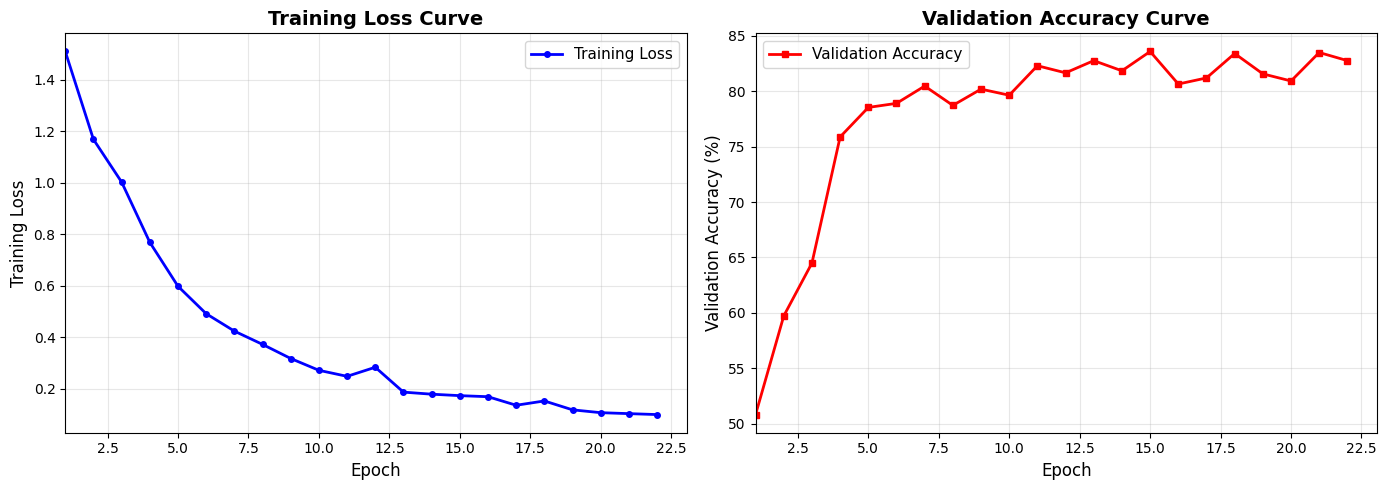


REGULARIZATION TUNING COMPLETE


In [21]:
# ============================================================================
# Regularization Final: All Best Combined
# ============================================================================
print("\n" + "="*80)
print("REGULARIZATION FINAL: ALL BEST SETTINGS COMBINED")
print("="*80)
print(f"Best settings from all steps:")
print(f"    Gradient Clipping: {best_grad_clip}")
print(f"    Dropout: {best_dropout}")
print(f"    L1 Lambda: {best_l1_lambda}")
print(f"    L2 Lambda: {best_l2_lambda}")

# Create model with all best settings
model = RNN_Classifier_Aggregation(
    vocab_size=embedding_vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=best_hidden_dim,
    output_dim=num_classes,
    n_layers=N_LAYERS,
    dropout=best_dropout,
    padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
    pretrained_embeddings=pretrained_embeddings,
    aggregation=best_aggregation['method']
).to(device)

# Select optimizer with best L2 (weight_decay)
if best_optimizer == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
elif best_optimizer == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=final_lr, momentum=0.9, weight_decay=best_l2_lambda)
elif best_optimizer == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)
elif best_optimizer == 'Adagrad':
    optimizer = optim.Adagrad(model.parameters(), lr=final_lr, weight_decay=best_l2_lambda)

# Training loop
best_val_acc = 0.0
patience_counter = 0

# Store training history for plotting
train_losses = []
val_accs = []

print(f"\n>>> Training final model with all best regularization settings...")

for epoch in range(MAX_EPOCHS):
    model.train()
    train_loss = 0
    train_preds = []
    train_labels = []
    num_batches = 0
    
    for batch in train_iter:
        num_batches += 1
        text, text_lengths, labels = process_batch(batch, debug=False)
        optimizer.zero_grad()
        predictions = model(text, text_lengths)
        
        loss = criterion(predictions, labels)
        
        if best_l1_lambda > 0:
            loss = loss + compute_l1_loss(model, best_l1_lambda)
        
        loss.backward()
        
        if best_grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), best_grad_clip)
        
        optimizer.step()
        
        train_loss += loss.item()
        preds = torch.argmax(predictions, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
    
    train_acc = accuracy_score(train_labels, train_preds)
    # Calculate average training loss (train_loss is sum over all batches)
    num_train_batches = len(train_labels) // train_iter.batch_size + (1 if len(train_labels) % train_iter.batch_size != 0 else 0)
    train_loss_avg = train_loss / num_train_batches if num_train_batches > 0 else train_loss
    
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for batch in val_iter:
            text, text_lengths, labels = process_batch(batch, debug=False)
            predictions = model(text, text_lengths)
            loss = criterion(predictions, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(predictions, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_acc = accuracy_score(val_labels, val_preds)
    
    # Store training history for plotting
    train_losses.append(train_loss_avg)
    val_accs.append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'rnn_reg_final_best.pt')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"    Early stopping at epoch {epoch+1}, best val acc: {best_val_acc*100:.2f}%")
            break
    
    if (epoch + 1) % 10 == 0:
        print(f"    Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Val Acc={val_acc*100:.2f}%")

# Evaluate on test set
model.load_state_dict(torch.load('rnn_reg_final_best.pt'))
model.eval()

test_loss = 0
test_preds = []
test_labels = []
test_probs = []

with torch.no_grad():
    for batch in test_iter:
        text, text_lengths, labels = process_batch(batch, debug=False)
        predictions = model(text, text_lengths)
        loss = criterion(predictions, labels)
        test_loss += loss.item()
        
        probs = torch.softmax(predictions, dim=1)
        preds = torch.argmax(predictions, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_loss_avg = test_loss / len(test_iter)

try:
    test_probs_array = np.array(test_probs)
    test_labels_bin = label_binarize(test_labels, classes=range(num_classes))
    test_auc = roc_auc_score(test_labels_bin, test_probs_array, average='weighted', multi_class='ovr')
except Exception as e:
    print(f"Warning: Could not calculate AUC-ROC: {e}")
    test_auc = 0.0

final_results = {
    'name': 'final_combined',
    'dropout': best_dropout,
    'grad_clip': best_grad_clip,
    'l1_lambda': best_l1_lambda,
    'l2_lambda': best_l2_lambda,
    'val_acc': best_val_acc,
    'test_acc': test_acc,
    'test_f1': test_f1,
    'test_auc': test_auc
}

print(f"\n>>> Final Combined Results:")
print(f"    Configuration:")
print(f"      - Gradient Clipping: {best_grad_clip}")
print(f"      - Dropout: {best_dropout}")
print(f"      - L1 Lambda: {best_l1_lambda}")
print(f"      - L2 Lambda: {best_l2_lambda}")
print(f"    Validation Acc: {best_val_acc*100:.2f}%")
print(f"    Test Acc: {test_acc*100:.2f}%")
print(f"    Test F1: {test_f1:.4f}")
print(f"    Test AUC-ROC: {test_auc:.4f}")

# Compare with baseline
improvement = test_acc - baseline_results['test_acc']
improvement_pct = (improvement / baseline_results['test_acc']) * 100 if baseline_results['test_acc'] > 0 else 0

print(f"\n>>> Comparison with Baseline:")
print(f"    Baseline Test Acc: {baseline_results['test_acc']*100:.2f}%")
print(f"    Final Regularized Test Acc: {test_acc*100:.2f}%")
print(f"    Improvement: {improvement*100:+.2f}% ({improvement_pct:+.2f}% relative)")

# Plot training curves for best configuration and regularization
print(f"\n>>> Plotting training curves for best configuration and regularization...")
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Loss vs Epochs
epochs = range(1, len(train_losses) + 1)
ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss Curve', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(left=1)

# Plot 2: Validation Accuracy vs Epochs
ax2.plot(epochs, [acc*100 for acc in val_accs], 'r-', label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Curve', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(left=1)

plt.tight_layout()
plt.savefig('best_config_training_curves.png', dpi=300, bbox_inches='tight')
print(f"    Saved training curves to 'best_config_training_curves.png'")
plt.show()

print(f"\n{'='*80}")
print("REGULARIZATION TUNING COMPLETE")
print(f"{'='*80}")


In [22]:
# ============================================================================
# Part 2(e): Topic-wise Accuracy Evaluation on Test Set
# ============================================================================
print("\n" + "="*80)
print("PART 2(e): TOPIC-WISE ACCURACY EVALUATION")
print("="*80)

# Load the best model from regularization tuning
# Use the model from the previous cell (regularization final) if available
# Otherwise, load it from the saved checkpoint

print("\n>>> Using model from regularization tuning...")

# Check if 'model' variable exists from the previous cell (cell 26)
try:
    # Try to use the model from the previous cell
    if 'model' in locals() or 'model' in globals():
        # Verify it's a valid model instance
        if hasattr(model, 'embedding') and hasattr(model, 'eval'):
            final_model = model
            final_model.eval()
            saved_vocab_size = final_model.embedding.weight.shape[0]
            print(f"    ✓ Using existing model from previous cell")
            print(f"    Model vocab size: {saved_vocab_size}")
        else:
            raise AttributeError("Model exists but is not valid")
    else:
        raise NameError("Model variable not found")
except (NameError, AttributeError):
    # Model doesn't exist or is invalid, load from checkpoint
    print("    Model not found in previous cell, loading from checkpoint...")
    try:
        checkpoint = torch.load('weights/rnn_reg_final_best.pt', map_location=device)
    except FileNotFoundError:
        checkpoint = torch.load('rnn_reg_final_best.pt', map_location=device)
    
    # Infer configuration from saved state dict
    saved_vocab_size = checkpoint['embedding.weight'].shape[0]
    saved_hidden_dim = checkpoint['rnn.weight_ih_l0'].shape[0]
    has_attention = 'attention.weight' in checkpoint
    saved_aggregation = 'attention' if has_attention else 'last'
    
    # Recreate model
    final_model = RNN_Classifier_Aggregation(
        vocab_size=saved_vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=saved_hidden_dim,
        output_dim=num_classes,
        n_layers=N_LAYERS,
        dropout=best_dropout,
        padding_idx=TEXT.vocab.stoi[TEXT.pad_token],
        pretrained_embeddings=None,
        aggregation=saved_aggregation
    ).to(device)
    
    final_model.load_state_dict(checkpoint, strict=True)
    final_model.eval()
    print(f"    ✓ Model loaded from checkpoint (vocab_size={saved_vocab_size})")

# Function to evaluate per topic
def evaluate_per_topic(model, iterator, device, max_vocab_size=None):
    """
    Evaluate model performance per topic category on the test set.
    Returns a dictionary with accuracy for each topic.
    
    Args:
        model: The trained model
        iterator: Data iterator for test set
        device: Device to run on
        max_vocab_size: Maximum valid vocabulary size (to clip token indices)
    """
    model.eval()
    
    # Dictionary to store correct and total counts per topic
    topic_correct = defaultdict(int)
    topic_total = defaultdict(int)
    
    # Get label vocabulary for mapping
    label_to_idx = LABEL.vocab.stoi
    idx_to_label = LABEL.vocab.itos
    
    # Get <unk> token index for mapping out-of-range tokens
    unk_idx = TEXT.vocab.stoi.get(TEXT.unk_token, 0)
    
    with torch.no_grad():
        for batch in iterator:
            # Process batch (should be on CPU from the iterator)
            text, text_lengths, labels = process_batch(batch, debug=False)
            
            # Clip token indices to valid range if max_vocab_size is specified
            # This handles cases where the current vocab is larger than the saved model's vocab
            if max_vocab_size is not None:
                # Map any indices >= max_vocab_size to <unk> token
                text = torch.where(text >= max_vocab_size, 
                                 torch.tensor(unk_idx, device=text.device, dtype=text.dtype), 
                                 text)
                # Also ensure no negative indices
                text = torch.clamp(text, min=0)
            
            # Move tensors to the actual device after clipping
            text = text.to(device)
            text_lengths = text_lengths.to(device)
            labels = labels.to(device)
            
            predictions = model(text, text_lengths)
            
            # Get predicted labels
            preds = torch.argmax(predictions, dim=1)
            
            # Convert to numpy for easier processing
            preds_np = preds.cpu().numpy()
            labels_np = labels.cpu().numpy()
            
            # Count correct and total for each topic
            for pred_idx, true_idx in zip(preds_np, labels_np):
                true_label = idx_to_label[true_idx]
                topic_total[true_label] += 1
                
                if pred_idx == true_idx:
                    topic_correct[true_label] += 1
    
    # Calculate accuracy per topic
    topic_accuracies = {}
    for label in sorted(topic_total.keys()):
        if topic_total[label] > 0:
            acc = topic_correct[label] / topic_total[label]
            topic_accuracies[label] = {
                'accuracy': acc,
                'correct': topic_correct[label],
                'total': topic_total[label]
            }
    
    return topic_accuracies

# Evaluate on test set
print("\n>>> Evaluating on test set...")

# Create a CPU iterator to avoid CUDA errors during numericalization with invalid token indices
# We'll process on CPU, clip indices, then move to device
from torchtext import data
cpu_device = torch.device('cpu')
test_iter_cpu = data.BucketIterator(
    test_data,
    batch_size=test_iter.batch_size,
    sort_key=lambda x: len(x.text),
    device=cpu_device,
    sort=False,
    shuffle=False
)

# Pass max_vocab_size to clip token indices to the saved model's vocabulary size
topic_accuracies = evaluate_per_topic(final_model, test_iter_cpu, device, max_vocab_size=saved_vocab_size)

# Display results
print("\n" + "="*80)
print("TOPIC-WISE ACCURACY ON TEST SET")
print("="*80)
print(f"{'Topic':<10} {'Accuracy':<12} {'Correct':<10} {'Total':<10} {'% of Test Set':<15}")
print("-" * 80)

# Calculate total test samples for percentage calculation
total_test_samples = sum(acc['total'] for acc in topic_accuracies.values())

for topic in sorted(topic_accuracies.keys()):
    acc_info = topic_accuracies[topic]
    acc_pct = acc_info['accuracy'] * 100
    correct = acc_info['correct']
    total = acc_info['total']
    pct_of_test = (total / total_test_samples) * 100 if total_test_samples > 0 else 0
    
    print(f"{topic:<10} {acc_pct:<12.2f} {correct:<10} {total:<10} {pct_of_test:<15.2f}")

# Calculate overall accuracy
overall_correct = sum(acc_info['correct'] for acc_info in topic_accuracies.values())
overall_total = sum(acc_info['total'] for acc_info in topic_accuracies.values())
overall_acc = overall_correct / overall_total if overall_total > 0 else 0

print("-" * 80)
print(f"{'OVERALL':<10} {overall_acc*100:<12.2f} {overall_correct:<10} {overall_total:<10} {'100.00':<15}")

# ============================================================================
# Discussion: What may cause differences in accuracies across topics
# ============================================================================
print("\n" + "="*80)
print("DISCUSSION: FACTORS AFFECTING TOPIC-WISE ACCURACY")
print("="*80)

# Get training distribution for comparison
train_label_counts = Counter([ex.label for ex in train_data.examples])
total_train = len(train_data.examples)

print("\n1. CLASS IMBALANCE IN TRAINING DATA:")
print(f"{'Topic':<10} {'Train Count':<15} {'Train %':<12} {'Test Count':<12} {'Test %':<12}")
print("-" * 70)
for topic in sorted(topic_accuracies.keys()):
    train_count = train_label_counts.get(topic, 0)
    train_pct = (train_count / total_train) * 100 if total_train > 0 else 0
    test_count = topic_accuracies[topic]['total']
    test_pct = (test_count / total_test_samples) * 100 if total_test_samples > 0 else 0
    print(f"{topic:<10} {train_count:<15} {train_pct:<12.2f} {test_count:<12} {test_pct:<12.2f}")

print("\n2. KEY OBSERVATIONS AND POTENTIAL CAUSES:")
print("\n   a) Class Imbalance Effect:")
print("      - Topics with fewer training examples (e.g., ABBR with only 1.58% of data)")
print("        may have lower accuracy due to insufficient learning signal")
print("      - The model may be biased toward more frequent classes during training")

print("\n   b) Semantic Complexity:")
print("      - Some topics may have more ambiguous or overlapping characteristics")
print("      - For example, ABBR (abbreviations) might be confused with other categories")
print("        if the context is not clear enough")

print("\n   c) Vocabulary and OOV Rates:")
print("      - Topics with higher OOV rates (as seen in Part 1) may have lower accuracy")
print("      - ABBR had 9.70% OOV rate (highest), which could contribute to lower performance")

print("\n   d) Question Type Characteristics:")
print("      - ENTY (entities) and HUM (humans) are more distinct and may be easier to classify")
print("      - DESC (descriptions) might overlap with other categories semantically")
print("      - NUM (numeric) questions may have distinctive patterns that aid classification")

print("\n   e) Model Capacity and Representation:")
print("      - The RNN may capture certain patterns better than others")
print("      - Aggregation method (attention/mean/max/last) may favor certain topic structures")

print("\n3. RECOMMENDATIONS FOR IMPROVEMENT:")
print("   - Use class weights in loss function to handle imbalance")
print("   - Apply data augmentation or oversampling for minority classes")
print("   - Consider focal loss to focus on hard examples")
print("   - Fine-tune embeddings specifically for underrepresented topics")
print("   - Use ensemble methods combining multiple models")

print("\n" + "="*80)
print("TOPIC-WISE EVALUATION COMPLETE")
print("="*80)



PART 2(e): TOPIC-WISE ACCURACY EVALUATION

>>> Using model from regularization tuning...
    ✓ Using existing model from previous cell
    Model vocab size: 8118

>>> Evaluating on test set...

TOPIC-WISE ACCURACY ON TEST SET
Topic      Accuracy     Correct    Total      % of Test Set  
--------------------------------------------------------------------------------
ABBR       66.67        6          9          1.80           
DESC       99.28        137        138        27.60          
ENTY       69.15        65         94         18.80          
HUM        90.77        59         65         13.00          
LOC        90.12        73         81         16.20          
NUM        84.96        96         113        22.60          
--------------------------------------------------------------------------------
OVERALL    87.20        436        500        100.00         

DISCUSSION: FACTORS AFFECTING TOPIC-WISE ACCURACY

1. CLASS IMBALANCE IN TRAINING DATA:
Topic      Train Count    